<a href="https://colab.research.google.com/github/larasauser/2024_MLEES/blob/main/Labs/S3_3_THOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ocean Regimes Identification

<img src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/ESLP1e1BfUxKu-hchh7wZKcBZiG3bJnNbnt0PDDm3BK-9g?download=1'>

<center>
Photo Credits: <a href="https://unsplash.com/photos/zCMWw56qseM">Sea Foam</a> by <a href="https://unsplash.com/@unstable_affliction">Ivan Bandura</a> licensed under the <a href='https://unsplash.com/license'>Unsplash License</a>
</center>


>*A frequently asked question related to this work is “Which mixing processes matter most for climate?” As with many alluringly comprehensive sounding questions, the answer is “it depends.”* <br>
> $\qquad$ MacKinnon, Jennifer A., et al. <br>$\qquad$"Climate process team on internal wave–driven ocean mixing." <br>$\qquad$ Bulletin of the American Meteorological Society 98.11 (2017): 2429-2454.

In week 4's final notebook, we will perform clustering to identify regimes in data taken from the realistic numerical ocean model [Estimating the Circulation and Climate of the Ocean](https://www.ecco-group.org/products-ECCO-V4r4.htm). Sonnewald et al. point out that finding robust regimes is intractable with a naïve approach, so we will be using reduced dimensionality data.

It is worth pointing out, however, that the reduction was done with an equation instead of one of the algorithms we discussed this week. If you're interested in the full details, you can check out [Sonnewald et al. (2019)](https://doi.org/10.1029/2018EA000519)

**Setup**

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [90]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import xarray as xr
import pooch

# to make this notebook's output stable across runs
rnd_seed = 42
rnd_gen = np.random.default_rng(rnd_seed)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Here we're going to import the [StandardScaler](https://duckduckgo.com/sklearn.preprocessing.standardscaler) function from scikit's preprocessing tools, import the [scikit clustering library](https://duckduckgo.com/sklearn.clustering), and set up the colormap that we will use when plotting.

In [91]:
from sklearn.preprocessing import StandardScaler
import sklearn.cluster as cluster

from matplotlib.colors import LinearSegmentedColormap, ListedColormap
colors = ['royalblue', 'cyan','yellow', 'orange', 'magenta', 'red']
mycmap = ListedColormap(colors)

**Data Preprocessing**

The first thing we need to do is retrieve the list of files we'll be working on. We'll rely on pooch to access the files hosted on the cloud.

In [92]:
# Retrieve the files from the cloud using Pooch.
data_url = 'https://unils-my.sharepoint.com/:u:/g/personal/tom_beucler_unil_ch/EUYqUzpIjoJBui02QEo6q1wBSN1Zsi1ofE6I3G4B9LJn_Q?download=1'
hash = '3f41661c7a087fa7d7af1d2a8baf95c065468f8a415b8514baedda2f5bc18bb5'

files = pooch.retrieve(data_url, known_hash=hash, processor=pooch.Unzip())
[print(filename) for filename in files];

/root/.cache/pooch/8a10ee1ae6941d8b9bb543c954c793fa-EUYqUzpIjoJBui02QEo6q1wBSN1Zsi1ofE6I3G4B9LJn_Q.unzip/curlB.npy
/root/.cache/pooch/8a10ee1ae6941d8b9bb543c954c793fa-EUYqUzpIjoJBui02QEo6q1wBSN1Zsi1ofE6I3G4B9LJn_Q.unzip/curlCori.npy
/root/.cache/pooch/8a10ee1ae6941d8b9bb543c954c793fa-EUYqUzpIjoJBui02QEo6q1wBSN1Zsi1ofE6I3G4B9LJn_Q.unzip/BPT.npy
/root/.cache/pooch/8a10ee1ae6941d8b9bb543c954c793fa-EUYqUzpIjoJBui02QEo6q1wBSN1Zsi1ofE6I3G4B9LJn_Q.unzip/curlTau.npy
/root/.cache/pooch/8a10ee1ae6941d8b9bb543c954c793fa-EUYqUzpIjoJBui02QEo6q1wBSN1Zsi1ofE6I3G4B9LJn_Q.unzip/noiseMask.npy
/root/.cache/pooch/8a10ee1ae6941d8b9bb543c954c793fa-EUYqUzpIjoJBui02QEo6q1wBSN1Zsi1ofE6I3G4B9LJn_Q.unzip/curlA.npy


And now that we have a set of files to load, let's set up a dictionary with the variable names as keys and the data in numpy array format as the values.

In [93]:
# Let's read in the variable names from the filepaths
var_names = []
[var_names.append(path.split('/')[-1][:-4]) for path in files]

# And build a dictionary of the data variables keyed to the filenames
data_dict = {}
for idx, val in enumerate(var_names):
    data_dict[val] = np.load(files[idx]).T

#We'll print the name of the variable loaded and the associated shape
[print(f'Varname: {item[0]:<15} Shape: {item[1].shape}') for item in data_dict.items()];

Varname: curlB           Shape: (360, 720)
Varname: curlCori        Shape: (360, 720)
Varname: BPT             Shape: (360, 720)
Varname: curlTau         Shape: (360, 720)
Varname: noiseMask       Shape: (360, 720)
Varname: curlA           Shape: (360, 720)


We now have a dictionary that uses the filename as the key! Feel free to explore the data (e.g., loading the keys, checking the shape of the arrays, plotting)

In [ ]:
#Feel free to explore the data dictionary

We're eventually going to have an array of cluster classes that we're going to use to label dynamic regimes in the ocean. Let's make an array full of NaN (not-a-number) values that has the same shape as our other variables and store it in the data dictionary.

In [94]:
data_dict['clusters'] = np.full_like(data_dict['BPT'], ~np.isnan(data_dict['BPT']))

In [95]:
print(data_dict['clusters'].shape)

(360, 720)


## Reformatting as Xarray

In the original paper, this data was loaded as numpy arrays. However, we'll take this opportunity to demonstrate the same procedure while relying on xarray. First, let's instantiate a blank dataset.<br><br>

### Q1) Make a blank xarray dataset.<br>
*Hint: Look at the xarray [documentation](https://duckduckgo.com/?q=xarray+dataset)*

In [96]:
# Make your blank dataset here! Instantiate the class without passing any parameters.

ds = xr.Dataset()

<img src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/EZv_qqVz_h1Hio6Nq11ckScBb01bGb9jtNKzdqAg1TPrKQ?download=1'>
<center> Image taken from the xarray <a href='https://xarray.pydata.org/en/stable/user-guide/data-structures.html#:~:text=Dataset-,xarray.,from%20the%20netCDF%20file%20format.'> <i>Data Structure documentation</i> </a> </center>

In order to build the dataset, we're going to need a set of coordinate vectors that help us map out our data! For our data, we have two axes corresponding to longitude ($\lambda$) and latitude ($\phi$).

We don't know much about how many lat/lon points we have, so let's explore one of the variables to make sense of the data the shape of one of the numpy arrays.

### Q2) Visualize the data using a plot and printing the shape of the data to the console output.

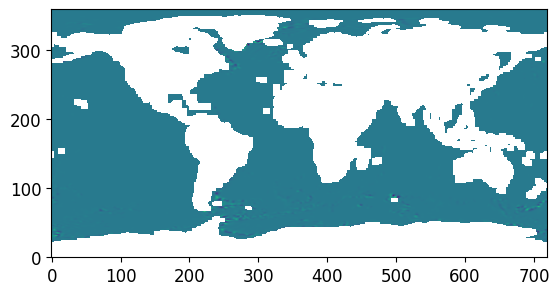

In [97]:
#Complete the code
# Let's print out an image of the Bottom Pressure Torques (BPT)
plt.imshow( data_dict['BPT'] , origin='lower')

In [98]:
# It will also be useful to store and print out the shape of the data
data_shape = data_dict['BPT'].shape
print(data_shape)

(360, 720)


Now that we know how the resolution of our data, we can prepare a set of axis arrays. We will use these to organize the data we will feed into the dataset.

### Q3) Prepare the latitude and longitude arrays to be used as axes for our dataset

*Hint 1: You can build ordered numpy arrays using, e.g., [numpy.linspace](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html) and [numpy.arange](https://numpy.org/doc/stable/reference/generated/numpy.arange.html)*

*Hint 2: You can rely on the data_shape variable we loaded previously to know how many points you need along each axis*

In [99]:
#Complete the code
# Let's prepare the lat and lon axes for our data.
lat = np.linspace(-90,90,data_shape[0])
lon = np.linspace(0,360,data_shape[1])

Now that we have the axes we need, we can build xarray [*data arrays*](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.html) for each data variable. Since we'll be doing it several times, let's go ahead and defined a function that does this for us!

### Q4) Define a function that takes in: 1) an array name, 2) a numpy array, 3) a lat vector, and 4) a lon vector. The function should return a dataArray with lat-lon as the coordinate dimensions

In [100]:
#Complete the code
def np_to_xr(array_name, array, lat, lon):
    #building the xarrray
    da = xr.DataArray(data = array, # Data to be stored

                  #set the name of dimensions for the dataArray
                  dims = ['lat', 'lon'],

                  #Set the dictionary pointing the name dimensions to np arrays
                  coords = {'lat':lat,
                            'lon':lon},

                  name=array_name)
    return da

We're now ready to build our data array! Let's iterate through the items and merge our blank dataset with the data arrays we create.

### Q5) Build the dataset from the data dictionary

*Hint: We'll be using the xarray merge command to put everything together.*

In [101]:
# The code in the notebook assumes you named your dataset ds. Change it to
# whatever you used!

# Complete the code
for key, item in data_dict.items():
    # Let's make use of our np_to_xr function to get the data as a dataArray
    da = np_to_xr(key, item, lat, lon)

    # Merge the dataSet with the dataArray here!
    ds = xr.merge( [ds , da ] )

Congratulations! You should now have a nicely set up xarray dataset. This let's you access a ton of nice features, e.g.:
> Data plotting by calling, e.g., `ds.BPT.plot.imshow(cmap='ocean')`
>
> Find statistical measures of all variables at once! (e.g.: `ds.std()`, `ds.mean()`)

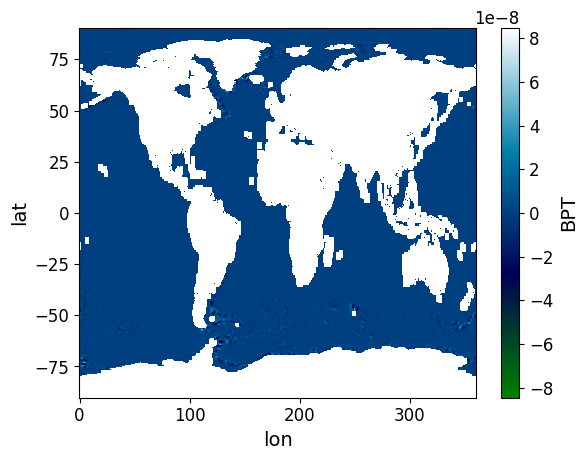

In [102]:
# Play around with the dataset here if you'd like :)
ds.BPT.plot.imshow(cmap='ocean')

Now we want to find clusters of data considering each grid point as a datapoint with 5 dimensional data. However, we went through a lot of work to get the data nicely associated with a lat and lon - do we really want to undo that?

Luckily, xarray developers foresaw the need to group dimensions together. Let's create a 'flat' version of our dataset using the [`stack`](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.stack.html) method. Let's make a flattened version of our dataset.

### Q6) Store a flattened version of our dataset

*Hint 1: You'll need to pass a dictionary with the 'new' stacked dimension name as the key and the 'flattened' dimensions as the values.*

*Hint 2: xarrays have a ['.values' attribute](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.values.html) that return their data as a numpy array.*

In [103]:
# Complete the code
# Let's store the stacked version of our dataset
stacked = ds.stack( { 'allpoints' :[ 'lat' , 'lon' ] } )

In [104]:
# And verify the shape of our data
print(stacked.to_array().values.shape)

(7, 259200)


So far we've ignored an important point - we're supposed to have 5 variables, not 6! As you may have guessed, `noiseMask` helps us throw away data we dont want (e.g., from land mass or bad pixels).

We're now going to clean up the stacked dataset using the noise mask. Relax and read through the code, since there won't be a question in this part :)

In [105]:
# Let's redefine stacked as all the points where noiseMask = 1, since noisemask
# is binary data.

print(f'Dataset shape before processing: {stacked.to_array().values.shape}')

print("Let's do some data cleaning!")
print(f'Points before cleaning: {len(stacked.BPT)}')
stacked = stacked.where(stacked.noiseMask==1, drop=True)
print(f'Points after cleaning: {len(stacked.BPT)}')

Dataset shape before processing: (7, 259200)
Let's do some data cleaning!
Points before cleaning: 259200
Points after cleaning: 149714


In [67]:
# We also no longer need the noiseMask variable, so we can just drop it.

print('And drop the noisemask variable...')
print(f'Before dropping: {stacked.to_array().values.shape}')
stacked = stacked.drop('noiseMask')
print(f'Dataset shape after processing: {stacked.to_array().values.shape}')

And drop the noisemask variable...
Before dropping: (7, 149714)
Dataset shape after processing: (6, 149714)


<ipython-input-67-53af3cff5b07>:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  stacked = stacked.drop('noiseMask')


We now have several thousand points which we want to divide into clusters using the kmeans clustering algorithm (you can check out the documentation for scikit's implementation of kmeans [here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)).

You'll note that the algorithm expects the input data `X` to be fed as `(n_samples, n_features)`. This is the opposite of what we have! Let's go ahead and make a copy to a numpy array has the axes in the right order.

You'll need xarray's [`.to_array()`](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.to_array.html) method and [`.values`](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.values.html) parameter, as well as numpy's [`.moveaxis`](https://numpy.org/doc/stable/reference/generated/numpy.moveaxis.html) method.

### Q7) Load the datapoints into a numpy array following the convention where the 0th axis corresponds to the samples and the 1st axis corresponds to the features.

In [68]:
# Complete the code
input_data = np.moveaxis(stacked.drop('clusters').to_array().values.squeeze(),  # data to reshape. Note that cluster is dropped since not needed for training
                         0,          # source axis as integer,
                         1)          # destination axis as integer

<ipython-input-68-4df119968cdd>:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  input_data = np.moveaxis(stacked.drop('clusters').to_array().values.squeeze(),  # data to reshape. Note that cluster is dropped since not needed for training


In [69]:
# Does the input data look the way it's supposed to? Print the shape.
print(np.shape(input_data))

(149714, 5)


## Kmeans clustering

In previous classes we discussed the importance of the scaling the data before implementing our algorithms. Now that our data is all but ready to be fed into an algorithm, let's make sure that it's been scaled.

### Q8) Scale the input data

*Hint 1: Import the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class from scikit and instantiate it*

*Hint 2: Update the input array to the one returned by the [`.fit_transform(X)`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.fit_transform) method*

In [70]:
#Write your scaling code here
scaler = StandardScaler()
input_data = scaler.fit_transform(input_data)

Now we're finally ready to train our algorithm! Let's load up the kmeans model and find clusters in our data.

### Q9) Instantiate the kmeans clustering algorithm, and then fit it using 50 clusters, trying out 10 different initial centroids.

*Hint 1: `sklearn.cluster` was imported as `cluser` during the notebook setup! [Here is the scikit `KMeans` documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).*

*Hint 2: Use the `fit_predict` method to organize the data into clusters*

*Warning! : Fitting the data may take some time (under a minute during the testing of the notebook)

In [71]:
# Complete the code
kmeans = cluster.KMeans(n_clusters =50,  # Number of clusters
                        random_state =42, # setting a random state
                        n_init =10, # Number of initial centroid states to try
                       verbose = 1)   # Verbosity so we know things are working

In [72]:
cluster_labels = kmeans.fit_predict(input_data) # Feed in out scaled input data!

Initialization complete
Iteration 0, inertia 178539.0098292412.
Iteration 1, inertia 162261.46194163503.
Iteration 2, inertia 158116.00261550563.
Iteration 3, inertia 156154.94948264523.
Iteration 4, inertia 154655.68230869836.
Iteration 5, inertia 153702.13580924892.
Iteration 6, inertia 152994.49606413775.
Iteration 7, inertia 152528.28110496432.
Iteration 8, inertia 152108.36268125765.
Iteration 9, inertia 151717.82923214673.
Iteration 10, inertia 151335.17681824.
Iteration 11, inertia 150967.80178906443.
Iteration 12, inertia 150535.0968668106.
Iteration 13, inertia 150130.06375057463.
Iteration 14, inertia 149635.23733039762.
Iteration 15, inertia 149153.54438292573.
Iteration 16, inertia 148761.87688258116.
Iteration 17, inertia 148454.96770510706.
Iteration 18, inertia 148201.86773876465.
Iteration 19, inertia 147982.7837860522.
Iteration 20, inertia 147743.0251571991.
Iteration 21, inertia 147451.36197518025.
Iteration 22, inertia 147153.6496246658.
Iteration 23, inertia 146876

We now have a set of cluster labels that group the data into 50 similar groups. Let's store it in our stacked dataset!

In [73]:
# Let's run this line
stacked['clusters'].values = cluster_labels

## Visualization

We now have a set of labels, but they're stored in a flattened array. Since we'd like to see the data as a map, we still have some work to do. Let's go back to a 2D representation of our values.

### Q10) Turn the flattened xarray back into a set of 2D fields
*Hint*: xarrays have an [`.unstack` method](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.unstack.html) that you will find to be very useful for this.

In [74]:
# Complete the code:
processed_ds = ds.unstack()

Now we have an unstacked dataset, and can now easily plot out the clusters we found!

### Q11) Plot the 'cluster' variable using the built-in xarray function
*Hint: `.plot()` [link text](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.html) let's you access the xarray implementations of [`pcolormesh`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.pcolormesh.html) and [`imshow`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.imshow.html).*

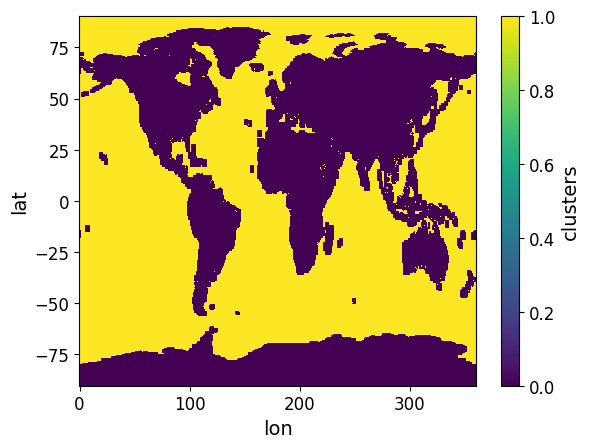

In [81]:
processed_ds['clusters'].plot.pcolormesh()

Compare your results to those from the paper:
<img src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/EdLh6Ds0yVlFivyfIOXlV74B_G35dVz87GFagzylIG-gZA?download=1'>

We now want to find the 5 most common regimes, and group the rest. This isn't straightforward, so we've gone ahead and prepared the code for you. Run through it and try to understand what the code is doing!

/usr/local/lib/python3.10/dist-packages/xarray/core/dataset.py:4802: UserWarning: No index created for dimension clusters because variable clusters is not a coordinate. To create an index for clusters, please first call `.set_coords('clusters')` on this object.
  warnings.warn(


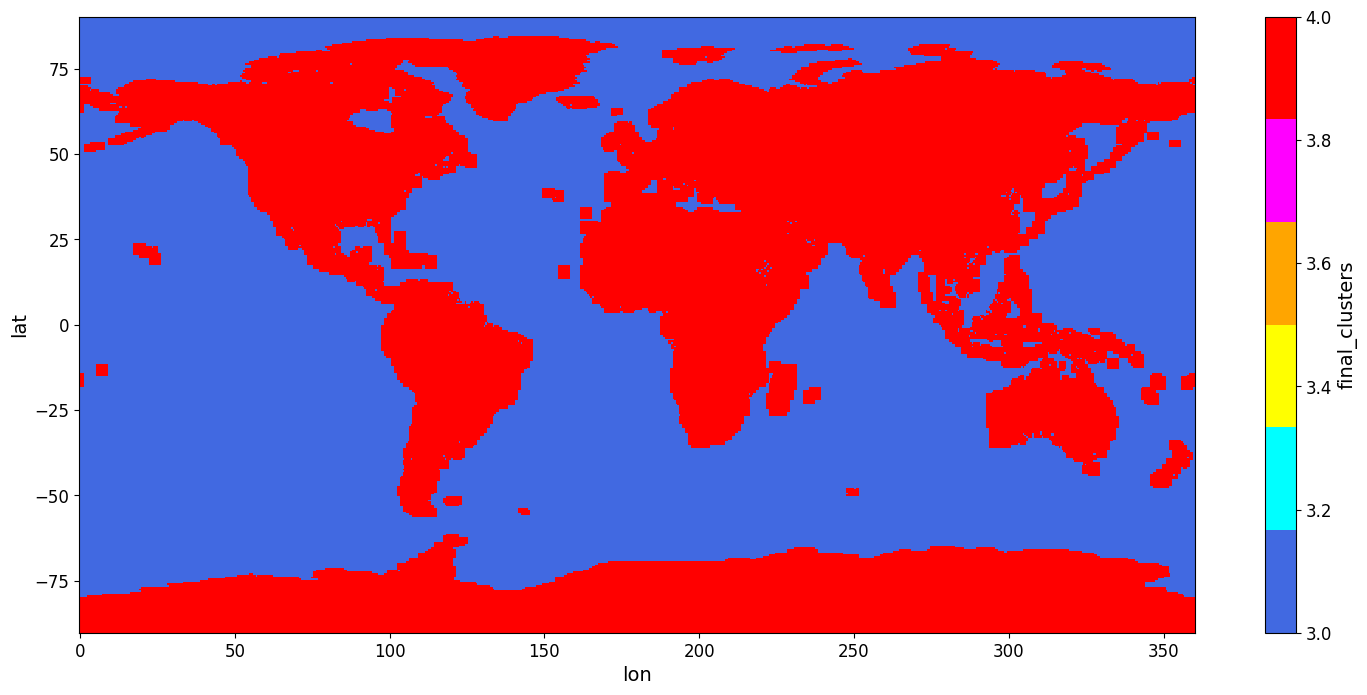

In [82]:
# Make field filled with -1 vals so unprocessed points are easily retrieved.
# Noise masked applied automatically by using previously found labels as base.
processed_ds['final_clusters'] = (processed_ds.clusters * 0) - 1

# Find the 5 most common cluster labels
top_clusters = processed_ds.groupby('clusters').count().sortby('BPT').tail(5).clusters.values

#Build the set of indices for the cluster data, used for rewriting cluster labels
for idx, label in enumerate(top_clusters):
    #Find the indices where the label is found
    indices = (processed_ds.clusters == label)

    processed_ds['final_clusters'].values[indices] = 4-idx

# Set the remaining unlabeled regions to category 5 "non-linear"
processed_ds['final_clusters'].values[processed_ds.final_clusters==-1] = 5

# Plot the figure
processed_ds.final_clusters.plot.imshow(cmap=mycmap, figsize=(18,8));

In [ ]:
# Feel free to use this space

Compare it to the regimes found in the paper:
<img src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/EehuR9cUfaJImrw4DCAzDPoBiGuG7R3Ys6453Umi1cN_OQ?download=1'>



The authors then went on to train neural networks ***to infer in-depth dynamics from data that is largely readily available from for example CMIP6 models, using NN methods to infer the source of predictive skill*** and ***to apply the trained Ensemble MLP to a climate model in order to assess circulation changes under global heating***.

For our purposes, however, we will say goodbye to *THOR* at this point 😃